# Recommender Systems
## Project Part 2 - Federated Learning
#### Library imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from math import log2
from scipy.sparse import csr_matrix
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from collections import Counter
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

project_path = r'C:\Users\Owner\Desktop\Msc Data Science\Recommender Systems\Project\BX-CSV-Dump'
np.set_printoptions(suppress=True)

### 1. Data Import/Exploration
* import `BX-Books.csv` dataset with book titles and general information
* import `BX-Book-Ratings.csv` dataset with book information
* import `BX-Users.csv` dataset with user information
* create dictionaries that map `user` and `book` ids with proper index ids
* create `numpy` matrix with ratings using index-valued ids
* divide ratings by `10` for scaling

In [2]:
# function to print dataframes
def pprint_df(dframe):
    print (tabulate(dframe, headers='keys', tablefmt='psql', showindex=False))
    
books = pd.read_csv(os.path.join(project_path, 'BX-Books.csv'), 
                    delimiter=';',
                    encoding='latin-1',
                    low_memory=False,
                    error_bad_lines=False
)
with pd.option_context('expand_frame_repr', False):
    print(books.iloc[0:3,1:5])
print('\nNumber of books:'+str(len(books)))

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\nSkipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\nSkipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\nSkipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


             Book-Title           Book-Author Year-Of-Publication                Publisher
0   Classical Mythology    Mark P. O. Morford                2002  Oxford University Press
1          Clara Callan  Richard Bruce Wright                2001    HarperFlamingo Canada
2  Decision in Normandy          Carlo D'Este                1991          HarperPerennial

Number of books:271360


In [3]:
users = pd.read_csv(os.path.join(project_path, 'BX-Users.csv'), 
                    delimiter=';',
                    encoding='ISO-8859–1'             
)
print(pprint_df(users.head(5)))
print('\nDistinct users:'+str(len(users)))

+-----------+------------------------------------+-------+
|   User-ID | Location                           |   Age |
|-----------+------------------------------------+-------|
|         1 | nyc, new york, usa                 |   nan |
|         2 | stockton, california, usa          |    18 |
|         3 | moscow, yukon territory, russia    |   nan |
|         4 | porto, v.n.gaia, portugal          |    17 |
|         5 | farnborough, hants, united kingdom |   nan |
+-----------+------------------------------------+-------+
None

Distinct users:278858


-------------------------------------------------
Original ratings sample: 
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6
-------------------------------------------------

Unique users: 105283
Unique books: 340556
Total number of ratings:  1149780

Transformed dataset sample: 
[[0.  0.  0. ]
 [1.  1.  0.5]
 [2.  2.  0. ]
 [3.  3.  0.3]
 [3.  4.  0.6]]


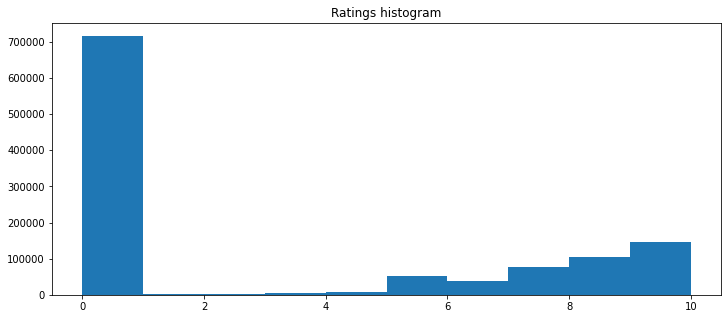

In [33]:
# import dataset
ratings = pd.read_csv(os.path.join(project_path, 'BX-Book-Ratings.csv'), 
                        delimiter=';',
                        encoding='ISO-8859–1'             
)
print('-------------------------------------------------')
print('Original ratings sample: ')
print(ratings.head(5))

# histogram:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.hist(ratings['Book-Rating'])
ax.title.set_text('Ratings histogram')

# create dictionaries with id mappings
n_users = ratings['User-ID'].nunique()
n_books = ratings['ISBN'].nunique()

unique_user_ids = ratings['User-ID'].unique()
user_dict = dict(zip(unique_user_ids,np.arange(n_users)))
user_dict_inv = dict(zip(np.arange(n_users),unique_user_ids))

unique_book_isbns = ratings['ISBN'].unique()
books_dict = dict(zip(unique_book_isbns,np.arange(n_books)))
books_dict_inv = dict(zip(np.arange(n_books),unique_book_isbns))

# create clean matrix with 
ratings['ISBN'] = ratings['ISBN'].map(books_dict).fillna(ratings['ISBN'])
ratings['User-ID'] = ratings['User-ID'].map(user_dict).fillna(ratings['User-ID']) 
ratings['Book-Rating'] = ratings['Book-Rating'].div(10)
ratings_df = ratings.copy(deep=True)
ratings = ratings.to_numpy(copy=True)
print('-------------------------------------------------')
print('\nUnique users: '+str(n_users))
print('Unique books: '+str(n_books))
print('Total number of ratings: ',len(ratings_df))
print('\nTransformed dataset sample: ')
print(ratings[:5])

* split dataset into training and test set

In [5]:
train_ratings, test_ratings = train_test_split(ratings, test_size=0.30, random_state=42, shuffle=True)

print('Train_ratings set:\n')
print(train_ratings[:3])
print('Train test number of ratings: ',len(train_ratings))
print('\nTest_ratings set:\n')
print(test_ratings[:3])
print('Test test number of ratings: ',len(test_ratings))

Train_ratings set:

[[ 51525.  20888.      0.]
 [ 81139. 269955.      0.]
 [ 87402.  42184.      0.]]
Train test number of ratings:  804846

Test_ratings set:

[[ 15560.   99291.       0. ]
 [ 49582.   59185.       0.8]
 [ 99796.  121427.       0. ]]
Test test number of ratings:  344934


### 2. Latent Factors with Baselines
Factorize Ratings matrix as $A = PQ $ where `P` is the user matrix of dimension $m \times k$ and `Q` is the item matrix of dimension $k \times n$
<br/>Estimate the unknown parameters by minimizing:
$$
\sum_{r_{ui} \in R_{train}}(r_{ui}-\hat{r_{ui}})^2 + \lambda (b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2)
$$
where
* $\hat{r_{ui}}$ is the predicted ratings of user `u` to the item `i`
* $r_{ui}$ is the ratings of user `u` to the item `i`
* $b_u$ the user biases
* $b_i$ the item biases
* $p_i$ the user factors
* $q_i$ the item factors
* $\lambda$ the regularization hyperparameter term
* $\mu$ is the global mean rating

The minimization is performed by stohastic gradient descent:
$$
b_u \leftarrow b_u + \gamma(e_{ui} - \lambda b_u) \\
b_i \leftarrow b_i + \gamma(e_{ui} - \lambda b_i) \\
p_u \leftarrow p_u + \gamma(e_{ui}q_i - \lambda p_u) \\
q_i \leftarrow q_i + \gamma(e_{ui}p_u - \lambda q_u)
$$
where $e_{ui} = r_{ui}-\hat{r_{ui}}$ and the prediction $\hat{r_{ui}} = \mu + b_u +b_i + q_i^Tp_u$

#### Metrics:
* Rooted Mean Squared Error: $RMSE= \sqrt{\frac{\sum(r_{ui} - \hat{r_{ui}})^2}{N}}$
* Mean Squared Error: $MSE= \frac{\sum(r_{ui} - \hat{r_{ui}})^2}{N}$
* Accuracy: $\frac{(TP + TN)}{(TP + TN + FP + FN)}$

In [6]:
def get_rmse(ratings, P, Q, bias_u, bias_i, m):
    N = ratings.shape[0]
    sum_errors = 0
    for u,i,r_ui in ratings:
        u_int = int(u)
        i_int = int(i)
        predicted = m + bias_u[u_int] + bias_i[i_int] + np.dot(P[u_int],Q[i_int])
        sum_errors += (predicted-r_ui)**2
    
    return np.sqrt(sum_errors/N) 

def get_mse(ratings, P, Q, bias_u, bias_i, m):
    predicted = []
    for u,i,r_ui in ratings:
        u_int = int(u)
        i_int = int(i)
        predicted.append(m + bias_u[u_int] + bias_i[i_int] + np.dot(P[u_int],Q[i_int]) )
    
    return mean_squared_error(ratings[:,2], predicted)

def get_accuracy(ratings, P, Q, bias_u, bias_i, m):
    predicted = []
    for u,i,r_ui in ratings:
        u_int = int(u)
        i_int = int(i)
        pred = m + bias_u[u_int] + bias_i[i_int] + np.dot(P[u_int],Q[i_int])
        pred = 1 if pred> 1 else 0 if pred < 0 else np.round(pred,1) 
        predicted.append(pred)
    
    return accuracy_score([int(10*i) for i in ratings[:,2]], [int(10*i) for i in predicted])

### Full method
* train using the whole training set for a number of epochs
* `decay`: reduces learning rate by a factor as epochs progress

In [11]:
#source: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

num_epochs = 20
n_factors = 4

alpha = 1e-1 # learning rate
decay=0 #alpha/num_epochs # https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
lamda = 0.01 # regularization parameter

# overall mean
overall_m_rating = train_ratings[:,2].mean()
#randomly initialize user/item factors from a Gaussian
P = np.random.normal(0,.1,(n_users,n_factors))
Q = np.random.normal(0,.1,(n_books,n_factors))
b_user = np.zeros(n_users)
b_item = np.zeros(n_books)


full_train_rmse = []
for epoch in range(num_epochs):
    for u,i,r_ui in train_ratings[np.random.permutation(train_ratings.shape[0])]:
        u_int = int(u)
        i_int = int(i)
        
        r_ui_pred = overall_m_rating + b_user[u_int] + b_item[i_int] + np.dot(P[u_int],Q[i_int])
        residual = r_ui - r_ui_pred
        
        # SGD Updates        
        b_user[u_int] += alpha*(residual - lamda*b_user[u_int])
        b_item[i_int] += alpha*(residual - lamda*b_item[i_int]) 
        temp = P[u_int] # we want to update them at the same time, so we make a temporary variable. 
        P[u_int] +=  alpha * (residual * Q[i_int] - lamda*temp)
        Q[i_int] +=  alpha * (residual * temp - lamda*Q[i_int])
    rmse = get_rmse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
    full_train_rmse.append(rmse)
    print('Epoch: ',epoch,'\t RMSE: %10.3f' % rmse,'\t lr: %1.3f' %  alpha)
    # reduce learning rate:
    alpha *= 1/(1 + decay * epoch)
    

Epoch:  0 	 RMSE:      0.313 	 lr: 0.100
Epoch:  1 	 RMSE:      0.295 	 lr: 0.100
Epoch:  2 	 RMSE:      0.283 	 lr: 0.100
Epoch:  3 	 RMSE:      0.271 	 lr: 0.100
Epoch:  4 	 RMSE:      0.262 	 lr: 0.100
Epoch:  5 	 RMSE:      0.253 	 lr: 0.100
Epoch:  6 	 RMSE:      0.245 	 lr: 0.100
Epoch:  7 	 RMSE:      0.237 	 lr: 0.100
Epoch:  8 	 RMSE:      0.230 	 lr: 0.100
Epoch:  9 	 RMSE:      0.223 	 lr: 0.100
Epoch:  10 	 RMSE:      0.218 	 lr: 0.100
Epoch:  11 	 RMSE:      0.213 	 lr: 0.100
Epoch:  12 	 RMSE:      0.208 	 lr: 0.100
Epoch:  13 	 RMSE:      0.204 	 lr: 0.100
Epoch:  14 	 RMSE:      0.201 	 lr: 0.100
Epoch:  15 	 RMSE:      0.197 	 lr: 0.100
Epoch:  16 	 RMSE:      0.194 	 lr: 0.100
Epoch:  17 	 RMSE:      0.192 	 lr: 0.100
Epoch:  18 	 RMSE:      0.190 	 lr: 0.100
Epoch:  19 	 RMSE:      0.187 	 lr: 0.100


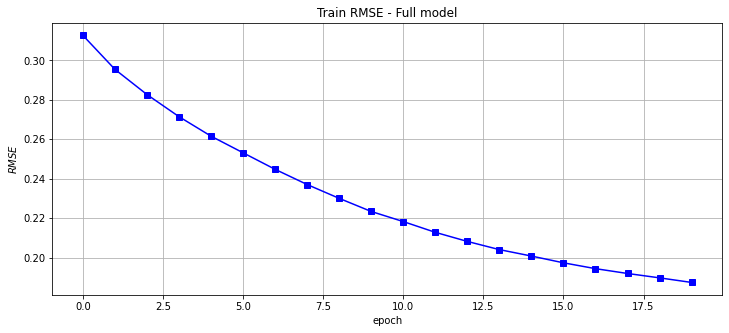

In [12]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(full_train_rmse, '-bs')
ax.set_ylabel('$RMSE$')
ax.set_xlabel('epoch')
ax.title.set_text('Train RMSE - Full model')
ax.grid()

#### Train and Test error metrics:

In [13]:
# Rooted Mean Squared Error
train_rmse = get_rmse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train RMSE: %2.2f' % train_rmse)
test_rmse = get_rmse(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test RMSE: %2.2f' % test_rmse)

print('==========================')

train_mse = get_mse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train MSE: %2.2f' % train_mse)
test_mse = get_mse(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test MSE: %2.2f' % test_mse)

print('==========================')

train_acc = get_accuracy(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train accuracy: %2.2f' % train_acc)
test_acc = get_accuracy(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test accuracy: %2.2f' % test_acc)

Train RMSE: 0.19
Test RMSE: 0.39
Train MSE: 0.04
Test MSE: 0.15
Train accuracy: 0.46
Test accuracy: 0.22


#### Check true ratings vs predictions for specific user:

In [23]:
user = 963
print(users[users['User-ID']==user_dict_inv[user]])
original_ratings = ratings_df.loc[ratings_df['User-ID']==user]

print('\n Original ratings')
print(original_ratings)

predicted_ratings=[]
for item in books_dict.values():
    predicted_ratings.append(overall_m_rating + b_user[user] + b_item[item] + np.dot(P[user],Q[item]))

print('----------------------------------------------------')

for item in original_ratings['ISBN'].values:
    print('Predicted rating of item: ',item,' is: ',np.round(predicted_ratings[item],2))


     User-ID                  Location  Age
325      326  parkville, missouri, usa  NaN

 Original ratings
       User-ID  ISBN  Book-Rating
10398      963  9643          1.0
----------------------------------------------------
Predicted rating of item:  9643  is:  0.94


#### Top 10 recommendations for specific user

In [34]:
top_10_predictions = np.argsort(predicted_ratings)[::-1][:10]
top_10_ISBNs = [books_dict_inv[index] for index in top_10_predictions]

print('----------------------------------------------------')
print('Top 10 predictions: ')
books[books.ISBN .isin(top_10_ISBNs)]

----------------------------------------------------
Top 10 predictions: 


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
44521,1570827893,Disney's Pooh's 123 (Learn and Grow.),Lisa Ann Marsoli,1998,Disney Press,http://images.amazon.com/images/P/1570827893.0...,http://images.amazon.com/images/P/1570827893.0...,http://images.amazon.com/images/P/1570827893.0...
140549,068982047X,The Bestest Mom (Rugrats),Susan Hood,1998,Simon Spotlight/Nickelodeon,http://images.amazon.com/images/P/068982047X.0...,http://images.amazon.com/images/P/068982047X.0...,http://images.amazon.com/images/P/068982047X.0...
172880,0803281781,Little Britches: Father and I Were Ranchers,Ralph Moody,1991,University of Nebraska Press,http://images.amazon.com/images/P/0803281781.0...,http://images.amazon.com/images/P/0803281781.0...,http://images.amazon.com/images/P/0803281781.0...
199879,0762102977,Yoga for Everybody/Not Everybody: Simple Routi...,Paul Harvey,2001,Reader's Digest Association,http://images.amazon.com/images/P/0762102977.0...,http://images.amazon.com/images/P/0762102977.0...,http://images.amazon.com/images/P/0762102977.0...
200440,0425091465,Inside the Green Berets,Charles M. Simpson,1986,Natl Book Network,http://images.amazon.com/images/P/0425091465.0...,http://images.amazon.com/images/P/0425091465.0...,http://images.amazon.com/images/P/0425091465.0...
200969,0446949280,Lots of Funny Riddles,Joseph Kiernan,1981,Warner Books,http://images.amazon.com/images/P/0446949280.0...,http://images.amazon.com/images/P/0446949280.0...,http://images.amazon.com/images/P/0446949280.0...


## Federated Averaging
1) Each user is a client with its own data, updates run iteratively for a few epochs on each client and server performs aggregations

In [39]:
num_rounds = 10
num_epochs = 3
n_factors = 4

alpha = 1e-1

# server initialization
overall_m_rating = train_ratings[:,2].mean()
P = np.random.normal(0,.1,(n_users,n_factors))
Q = np.random.normal(0,.1,(n_books,n_factors))
b_user = np.zeros(n_users)
b_item = np.zeros(n_books)
lamda = 0.1
N = train_ratings.shape[0]

fl_train_rmse=[]
for round in range(num_rounds):
    P_sum = np.zeros((n_users,n_factors))
    Q_sum = np.zeros((n_books,n_factors))
    b_user_sum = np.zeros(n_users)
    b_item_sum = np.zeros(n_books)
    # for each user-client
    for user in range(n_users):
        
        # broadcast server weights to client:
        P_client = P.copy()
        Q_client = Q.copy()
        b_user_client = b_user.copy()
        b_item_client = b_item.copy()
        # update weights using only client's dataset
        user_dataset = train_ratings[train_ratings[:,0]==user]
        user_dataset = user_dataset[np.random.permutation(user_dataset.shape[0])] #shuffle
        N_client = user_dataset.shape[0]
        for epoch in range(num_epochs):
            for u,i,r_ui in user_dataset:
                u_int = int(u)
                i_int = int(i)

                r_ui_pred = overall_m_rating + b_user_client[u_int] + b_item_client[i_int] + np.dot(P_client[u_int], Q_client[i_int])
                residual = r_ui - r_ui_pred

                # SGD Updates        
                b_user_client[u_int] += alpha*(residual - lamda*b_user_client[u_int])
                b_item_client[i_int] += alpha*(residual - lamda*b_item_client[i_int]) 
                temp = P_client[u_int] # we want to update them at the same time, so we make a temporary variable. 
                P_client[u_int] +=  alpha * (residual * Q_client[i_int] - lamda*temp)
                Q_client[i_int] +=  alpha * (residual * temp - lamda*Q_client[i_int])
        
        # running average:
        P_sum += (N_client/N)*P_client
        Q_sum += (N_client/N)*Q_client
        b_user_sum += (N_client/N)*b_user_client
        b_item_sum += (N_client/N)*b_item_client
        
        #if user % 1000 == 0:
        #    print('Completed for user: ',user,' percentage: ', 100*round(user/n_users,2),'%')
    P = P_sum.copy()
    Q = Q_sum.copy()
    b_user = b_user_sum.copy()
    b_item = b_item_sum.copy()
    print('Finished round: ', round)
    rmse = get_rmse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
    fl_train_rmse.append(rmse)
    print('After round: ',round,'\t RMSE: %10.3f' % rmse)
        

Finished round:  0
After round:  0 	 RMSE:      0.386
Finished round:  1
After round:  1 	 RMSE:      0.386
Finished round:  2
After round:  2 	 RMSE:      0.386
Finished round:  3
After round:  3 	 RMSE:      0.385
Finished round:  4
After round:  4 	 RMSE:      0.385
Finished round:  5
After round:  5 	 RMSE:      0.385
Finished round:  6
After round:  6 	 RMSE:      0.385
Finished round:  7
After round:  7 	 RMSE:      0.385
Finished round:  8
After round:  8 	 RMSE:      0.385
Finished round:  9
After round:  9 	 RMSE:      0.384


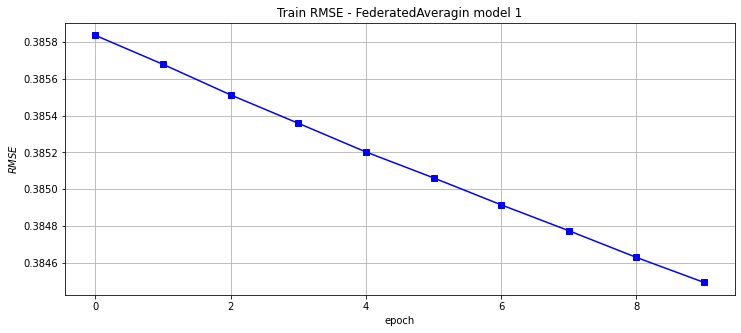

In [40]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(fl_train_rmse, '-bs')
ax.set_ylabel('$RMSE$')
ax.set_xlabel('epoch')
ax.title.set_text('Train RMSE - FederatedAvg model 1')
ax.grid()

In [41]:
# Rooted Mean Squared Error
train_rmse = get_rmse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train RMSE: %2.2f' % train_rmse)
test_rmse = get_rmse(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test RMSE: %2.2f' % test_rmse)

print('==========================')

train_mse = get_mse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train MSE: %2.2f' % train_mse)
test_mse = get_mse(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test MSE: %2.2f' % test_mse)

print('==========================')

train_acc = get_accuracy(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train accuracy: %2.2f' % train_acc)
test_acc = get_accuracy(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test accuracy: %2.2f' % test_acc)

Train RMSE: 0.38
Test RMSE: 0.38
Train MSE: 0.15
Test MSE: 0.15
Train accuracy: 0.01
Test accuracy: 0.01


2) Divide dataset into 100 clients, run for a few epochs on each client

In [36]:
num_rounds = 80
num_epochs = 5
n_factors = 4
num_clients=100
alpha = 1e-1
lamda = 0.1

np.random.seed(94)

# server initialization
overall_m_rating = train_ratings[:,2].mean()
P = np.random.normal(0,.1,(n_users,n_factors))
Q = np.random.normal(0,.1,(n_books,n_factors))
b_user = np.zeros(n_users)
b_item = np.zeros(n_books)

N = train_ratings.shape[0]
chunk_size = N //num_clients

fl_train_rmse2=[]
for round in range(num_rounds):
    P_sum = np.zeros((n_users,n_factors))
    Q_sum = np.zeros((n_books,n_factors))
    b_user_sum = np.zeros(n_users)
    b_item_sum = np.zeros(n_books)
    # for each user-client
    for client in range(num_clients):
        
        # broadcast server weights to client:
        P_client = P.copy()
        Q_client = Q.copy()
        b_user_client = b_user.copy()
        b_item_client = b_item.copy()
        # update weights using only client's dataset
        client_dataset = train_ratings[client*chunk_size+1:(client+1)*chunk_size]
        N_client = client_dataset.shape[0]
        for epoch in range(num_epochs):
            for u,i,r_ui in client_dataset[np.random.permutation(client_dataset.shape[0])]:
                u_int = int(u)    
                i_int = int(i)

                r_ui_pred = overall_m_rating + b_user_client[u_int] + b_item_client[i_int] + np.dot(P_client[u_int], Q_client[i_int])
                residual = r_ui - r_ui_pred

                # SGD Updates        
                b_user_client[u_int] += alpha*(residual - lamda*b_user_client[u_int])
                b_item_client[i_int] += alpha*(residual - lamda*b_item_client[i_int]) 
                temp = P_client[u_int] # we want to update them at the same time, so we make a temporary variable. 
                P_client[u_int] +=  alpha * (residual * Q_client[i_int] - lamda*temp)
                Q_client[i_int] +=  alpha * (residual * temp - lamda*Q_client[i_int])
        
        # running average:
        P_sum += (N_client/N)*P_client
        Q_sum += (N_client/N)*Q_client
        b_user_sum += (N_client/N)*b_user_client
        b_item_sum += (N_client/N)*b_item_client
        
        #if user % 4000 == 0:
        #    print('Completed for user: ',user,' percentage: ', 100*round(user/n_users,2),'%')
    P = P_sum.copy()
    Q = Q_sum.copy()
    b_user = b_user_sum.copy()
    b_item = b_item_sum.copy()
    print('Finished round: ', round)
    rmse = get_rmse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
    fl_train_rmse2.append(rmse)
    print('After round: ',round,'\t RMSE: %10.3f' % rmse)
        


Finished round:  0
After round:  0 	 RMSE:      0.356
Finished round:  1
After round:  1 	 RMSE:      0.349
Finished round:  2
After round:  2 	 RMSE:      0.344
Finished round:  3
After round:  3 	 RMSE:      0.341
Finished round:  4
After round:  4 	 RMSE:      0.338
Finished round:  5
After round:  5 	 RMSE:      0.336
Finished round:  6
After round:  6 	 RMSE:      0.334
Finished round:  7
After round:  7 	 RMSE:      0.332
Finished round:  8
After round:  8 	 RMSE:      0.330
Finished round:  9
After round:  9 	 RMSE:      0.328
Finished round:  10
After round:  10 	 RMSE:      0.327
Finished round:  11
After round:  11 	 RMSE:      0.326
Finished round:  12
After round:  12 	 RMSE:      0.324
Finished round:  13
After round:  13 	 RMSE:      0.323
Finished round:  14
After round:  14 	 RMSE:      0.322
Finished round:  15
After round:  15 	 RMSE:      0.321
Finished round:  16
After round:  16 	 RMSE:      0.320
Finished round:  17
After round:  17 	 RMSE:      0.319
Finished rou

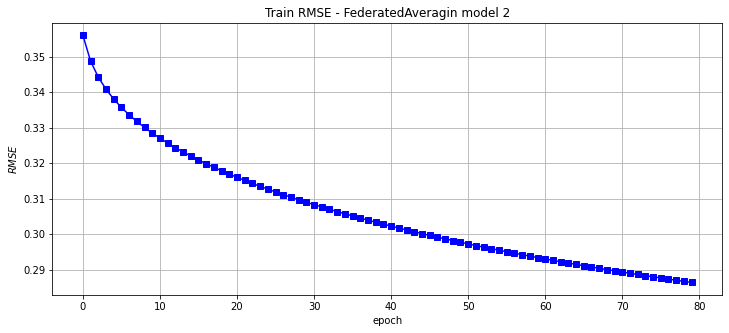

In [37]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(fl_train_rmse2, '-bs')
ax.set_ylabel('$RMSE$')
ax.set_xlabel('epoch')
ax.title.set_text('Train RMSE - FederatedAvg model 2')
ax.grid()

In [38]:
# Rooted Mean Squared Error
train_rmse = get_rmse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train RMSE: %2.2f' % train_rmse)
test_rmse = get_rmse(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test RMSE: %2.2f' % test_rmse)

print('==========================')
# Mean Squared Error
train_mse = get_mse(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train MSE: %2.2f' % train_mse)
test_mse = get_mse(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test MSE: %2.2f' % test_mse)

print('==========================')
# Accuracy
train_acc = get_accuracy(train_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Train accuracy: %2.2f' % train_acc)
test_acc = get_accuracy(test_ratings, P, Q, b_user, b_item, overall_m_rating)
print('Test accuracy: %2.2f' % test_acc)

Train RMSE: 0.29
Test RMSE: 0.34
Train MSE: 0.08
Test MSE: 0.12
Train accuracy: 0.13
Test accuracy: 0.11
